In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as shc
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, normalizem
import operator as op
import warnings

# Kmeans Clustering to find clusters with high churn

### In this model we will create  one or 2 clusters with high percentage churn and the other clusters will have lower percentages of churn. <br>We will perform some data exploration to determine what data will be useful to the model.


#### The use of creating these clusters is that any company that uses this model will be able to determine what parts of their customer base has high churn.

In [2]:
df=pd.read_csv("Bank Customer Churn Prediction.csv")
churn_col=df["churn"]
df.info()
df_saved=df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


#### As we see above we have 11 different columns

| Name | Description |
| --- | --- |
| *Customer ID* | This is the ID of the customer. This is **not useful** to the model. |
| *Credit Score* | This is could be **extremly relevent** data. Credit score determines a lot about a person's access to features. |
| *Country* | This **could be useful**. However the dataset might be of a limited / selective to an area |
| *Gender* | Usually **should not be useful**. Has some uses sometimes. |
| *Age* | **Genearlly important**. Determines spending and saving habits |
| *Tenure* | This is a **badly named** column. Refers to how long the customer has been doing bussiness. **Could be useful.** |
| *Balance* | This usually **is important** |
| *Product Number* | **Might be useful.** |
| *Credit Card* | **Might not be useful.** Can be considered redundent data because we have credit score |
| *Active Memeber* | Has **potential to be useful.** Might not be in this case. |
| *Estimated Salary* | **Could be useful.** Certain set of salaries often choose similar banks |
| *Churn* | Important **for verification** | 

Customer_Id and churn column will not be used to train our model.<br> Here we remove them.

In [3]:
df_temp=df
df=df.drop(['customer_id','churn'],axis=1).copy()

## Now we will visualize the data and see if we can determine anything.

##### This is basic exploratory data analysis

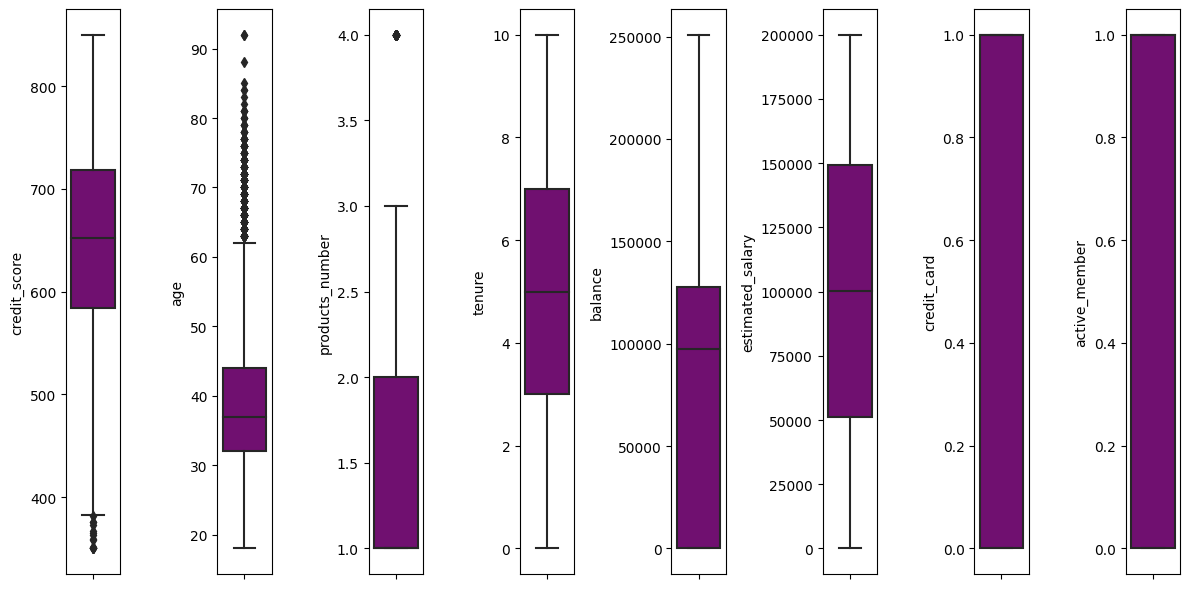

In [4]:
plt.figure(figsize=(12,6))
numericals= ['credit_score','age','products_number','tenure','balance','estimated_salary','credit_card','active_member']

# plotting
features = numericals
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df_temp[features[i]], color='purple')
    plt.tight_layout()

### If u see above it looks like age has a lot of outliers. <br> However this is **not** the case. After some analysis we will realise that the "outliers" are just different clusters.

C:\Users\Anirudha\AppData\Local\Temp\ipykernel_12248\2472345924.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df_temp.corr()


<AxesSubplot: >

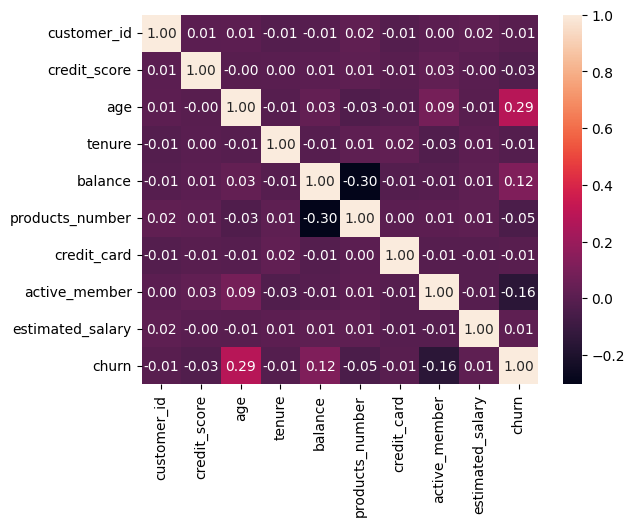

In [5]:
correlation = df_temp.corr()
sns.heatmap(correlation, annot=True, fmt='.2f')

### You can see above that the age, balance, a member's activity has a correlation to churn.

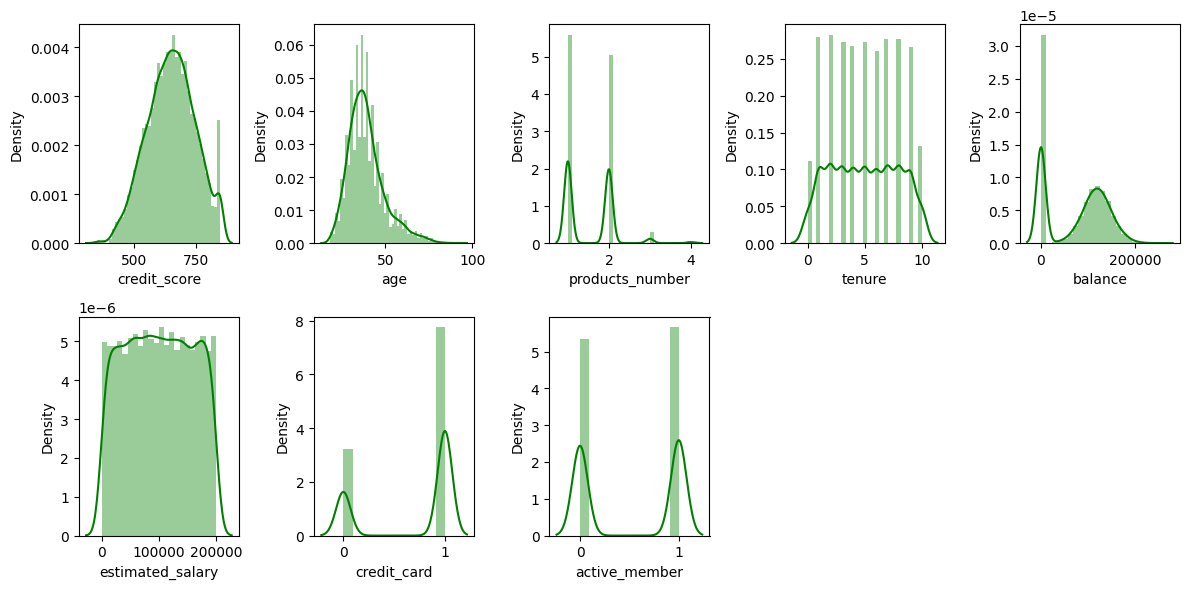

In [6]:
plt.figure(figsize=(12,6))
warnings.filterwarnings("ignore")

features = numericals
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    #plt.subplot(1, len(features), i+1)
    sns.distplot(x=df_temp[features[i]], color='green')
    plt.xlabel(features[i])
    plt.tight_layout()

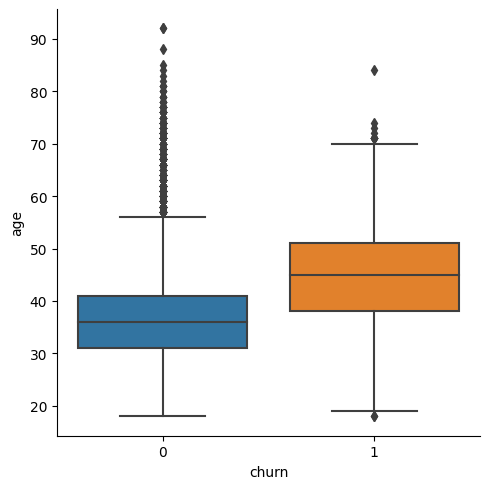

In [7]:
sns.catplot(x = 'churn', y="age", kind="box", data =df_temp )

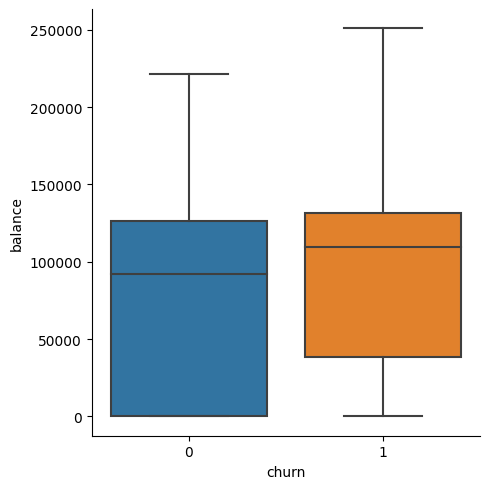

In [8]:
sns.catplot(x = 'churn', y="balance", kind="box", data = df_temp)

#### We can see above both age and balance have some parts that do not overlap ie parts that could be "features" or Unique properties of the clusters. 

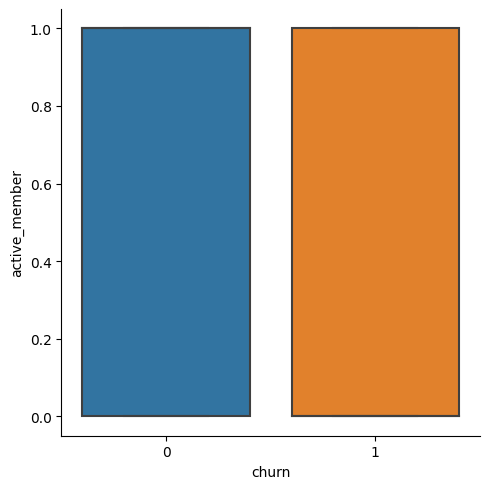

In [9]:
sns.catplot(x = 'churn', y="active_member", kind="box", data = df_temp)

#### Hmmm, it looks as though there is not correlation between active member and churn. However we should remember that active member has only 2 values! So visualizing using a box plot like this will not reveal anything to us.

## Now we will perpare the data.
### First we determine what are numeric and non numerical data.

In [10]:

######################################################
# THIS IS AN ALTERNATE TO REGULAR LIST COMPREHENTION #
######################################################
num_index = (df.dtypes != 'object')
print(num_index)
non_num_index = (df.dtypes == 'object')

#List of index of all number features.
num_feature=list(num_index[num_index].index)

#List of all non nnumber based features.
non_num_feature=list(non_num_index[non_num_index].index)
print(num_feature)

credit_score         True
country             False
gender              False
age                  True
tenure               True
balance              True
products_number      True
credit_card          True
active_member        True
estimated_salary     True
dtype: bool
['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']


In [11]:
df.head()
df_noscale=df.copy()

### The values in a few columes are extremly large. Here we will scale them down.

In [12]:
scaler = MinMaxScaler()
df[num_feature] = scaler.fit_transform(df[num_feature])


### We will encode the non numberic features.

In [13]:
encoder = OrdinalEncoder()
df[non_num_feature] = encoder.fit_transform(df[non_num_feature])
df_noscale[non_num_feature] = encoder.fit_transform(df_noscale[non_num_feature])
print(df.head())


   credit_score  country  gender       age  tenure   balance  products_number  \
0         0.538      0.0     0.0  0.324324     0.2  0.000000         0.000000   
1         0.516      2.0     0.0  0.310811     0.1  0.334031         0.000000   
2         0.304      0.0     0.0  0.324324     0.8  0.636357         0.666667   
3         0.698      0.0     0.0  0.283784     0.1  0.000000         0.333333   
4         1.000      2.0     0.0  0.337838     0.2  0.500246         0.000000   

   credit_card  active_member  estimated_salary  
0          1.0            1.0          0.506735  
1          0.0            1.0          0.562709  
2          1.0            0.0          0.569654  
3          0.0            0.0          0.469120  
4          1.0            1.0          0.395400  


In [14]:
#These are approximate values.
age_factor=0.324324/42
balance_factor=0.334031/83807.86

### Here we will perform something like the elbow method(KNN) for K Means.

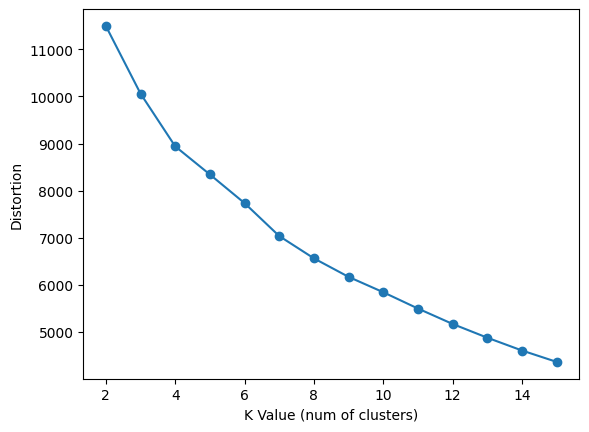

In [15]:
num_clusters=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
inertia=[]
for k in range(2,16):
    model=KMeans(init='k-means++',n_clusters=k,random_state=0,algorithm="elkan")
    model.fit(df)
    inertia.append(model.inertia_)

plt.plot(num_clusters, inertia, '-o')
plt.xlabel('K Value (num of clusters)')
plt.ylabel('Distortion')
plt.show()

* `Inertia is a measure of how "well" the data was clustered. It is calculated by measuring the distance between the each datapoint and its centroid, squaring this and summing all the squares across one cluster.`<br>
* `Distortion is the average of inertias for all the clusters. This is shown in the graph above.`
* `The elbow is more visible/ Obvious if we do not normalize / scale the data. However if we do not normalize / scale the data KMeans will struggle a lot.`

The above graph shows the relation between distortion and the K values. We can see that 4 is the elbow. <br>
However another interesting observaiton about this dataset is this value is a lot more apparent if we do not normalize this data. However if we dont mormalize, the models do not perform well.

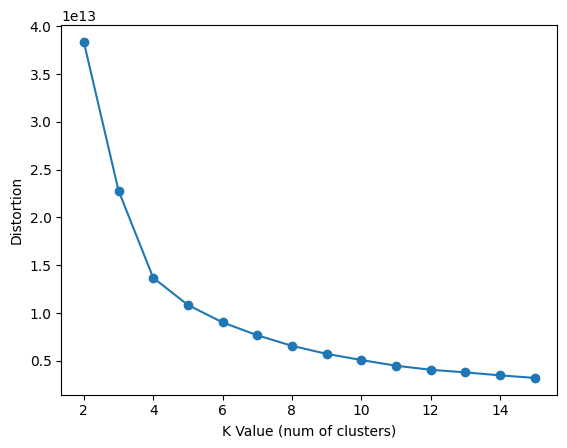

In [16]:
num_clusters=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
inertia=[]
for k in range(2,16):
    model=KMeans(init='k-means++',n_clusters=k,random_state=0,algorithm="elkan")
    model.fit(df_noscale)
    inertia.append(model.inertia_)

plt.plot(num_clusters, inertia, '-o')
plt.xlabel('K Value (num of clusters)')
plt.ylabel('Distortion')
plt.show()

# Now we actually start making the model.
### At first we will not use the results from the exploratory data analysis. This is so that we can demonstrate the use of the exploration.
##### I will be using elkan's algorithmn rather than Lloyd's algorithm as it performed faster and slightly better on my computer. Generally elkan is faster with higher dimentions as seen in [here](https://www.cse.iitd.ac.in/~rjaiswal/2015/col870/Project/Nipun.pdf)

` class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, algorithm='lloyd' `
| Hyperparameters | Description |
| --- | --- |
| ` n_clusters ` | The number of clusters to form as well as the number of centroids to generate. |
| ` init ` ('k-means++', 'random') | 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points contribution to the overall inertia. <br> 'random': choose n_clusters observations (rows) at random from data for the initial centroids. <br> We can also pass an array to initialize centroids ourselves. |
| ` n_init ` | Number of time the k-means algorithm will be re initialized. It will use different centroids each time. |
| ` max_iter ` | Maximum number of iterations of the k-means algorithm for a single initialized. |
| ` tol ` | Relative tolerance with regards to Frobenius norm (Square root of the sum of the squares). It is used to declare convergence. |
| ` verbose ` | Verbosity mode. This is used to get more outputs from the funciton. In case we want to see more inner working of the function |
| ` random_state ` | Determines random number generation for centroid initialization. |
| ` algorithm ` ('lloyd', 'elkan', 'auto', 'full') | Lloyd, full, auto are the same. Here we will use Elkan's algorithm |

<br>

| Outputs | Description |
| --- | --- |
| cluster_centers_ (n_clusters, n_features)| Coordinates of cluster centers. |
| inertia_float | Sum of squared distances of samples to their closest cluster center. |
| n_iter_int | Number of iterations run. |



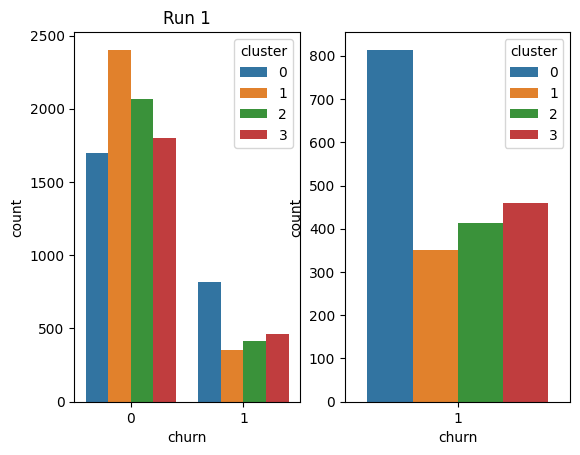

In [17]:
#Creating and fitting the model
model = KMeans(init='k-means++', n_clusters=4, random_state=0,algorithm="elkan")
model.fit(df)

df['cluster'] = model.predict(df)
df['churn'] = churn_col

ply,ax=plt.subplots(1,2)
sns.countplot(x='churn', hue="cluster", data=df,ax=ax[0]).set(title='Run 1')

new_thing=[[i,j] for i,j in zip(df["churn"],df['cluster']) if i==1]
dfn = pd.DataFrame(list(new_thing),columns =['churn', 'cluster'])
sns.countplot(x='churn', hue="cluster", data=dfn,ax=ax[1])
ply.show()



In [18]:
new_thing_A=new_thing

for i in new_thing:
    del i[0]

new_thing=[int(i[0])for i in new_thing]
new_thing_A=[j for i,j in zip(df["churn"],df['cluster'])]

for i in range(4):
    print("Cluster "+str(i)+" Churn %=>",end="")
    print(round(float(op.countOf(new_thing,i)/op.countOf(new_thing_A,i)*100),3),end="%\n")


Cluster 0 Churn %=>32.443%
Cluster 1 Churn %=>12.713%
Cluster 2 Churn %=>16.673%
Cluster 3 Churn %=>20.345%


## We can see that cluster 1 has considerably more churn than any other cluster.<br>
### Let us repeat a few times so that we can be sure that cluster 1 is always maximum churn.

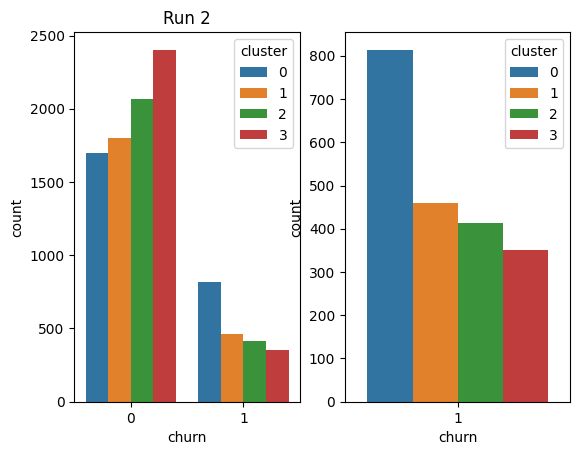

In [19]:

model = KMeans(init='k-means++', n_clusters=4, random_state=0,algorithm="elkan")
model.fit(df)

df['cluster'] = model.predict(df)
df['churn'] = churn_col

ply,ax=plt.subplots(1,2)
sns.countplot(x='churn', hue="cluster", data=df,ax=ax[0]).set(title='Run 2')


new_thing=[[i,j] for i,j in zip(df["churn"],df['cluster']) if i==1]
dfn = pd.DataFrame(list(new_thing),columns =['churn', 'cluster'])
sns.countplot(x='churn', hue="cluster", data=dfn,ax=ax[1])
ply.show()



In [20]:
new_thing_A=new_thing

for i in new_thing:
    del i[0]

new_thing=[int(i[0])for i in new_thing]
new_thing_A=[j for i,j in zip(df["churn"],df['cluster'])]

for i in range(4):
    print("Cluster "+str(i)+" Churn %=>",end="")
    print(round(float(op.countOf(new_thing,i)/op.countOf(new_thing_A,i)*100),3),end="%\n")


Cluster 0 Churn %=>32.443%
Cluster 1 Churn %=>20.345%
Cluster 2 Churn %=>16.673%
Cluster 3 Churn %=>12.713%


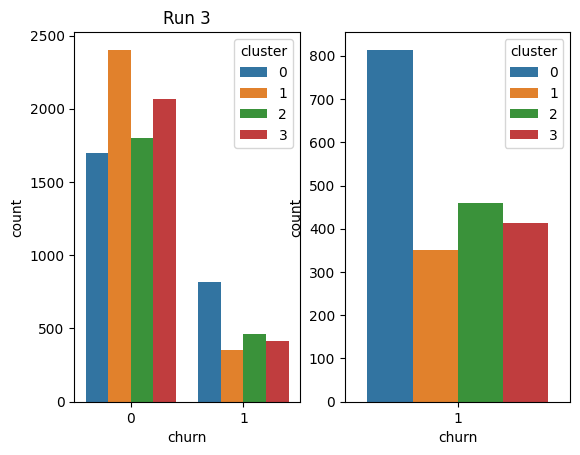

In [21]:

model = KMeans(init='k-means++', n_clusters=4, random_state=0,algorithm="elkan")
model.fit(df)

df['cluster'] = model.predict(df)
df['churn'] = churn_col

ply,ax=plt.subplots(1,2)
sns.countplot(x='churn', hue="cluster", data=df,ax=ax[0]).set(title='Run 3')


new_thing=[[i,j] for i,j in zip(df["churn"],df['cluster']) if i==1]
dfn = pd.DataFrame(list(new_thing),columns =['churn', 'cluster'])
sns.countplot(x='churn', hue="cluster", data=dfn,ax=ax[1])
ply.show()



In [22]:
new_thing_A=new_thing

for i in new_thing:
    del i[0]

new_thing=[int(i[0])for i in new_thing]
new_thing_A=[j for i,j in zip(df["churn"],df['cluster'])]

for i in range(4):
    print("Cluster "+str(i)+" Churn %=>",end="")
    print(round(float(op.countOf(new_thing,i)/op.countOf(new_thing_A,i)*100),3),end="%\n")


Cluster 0 Churn %=>32.443%
Cluster 1 Churn %=>12.713%
Cluster 2 Churn %=>20.345%
Cluster 3 Churn %=>16.673%


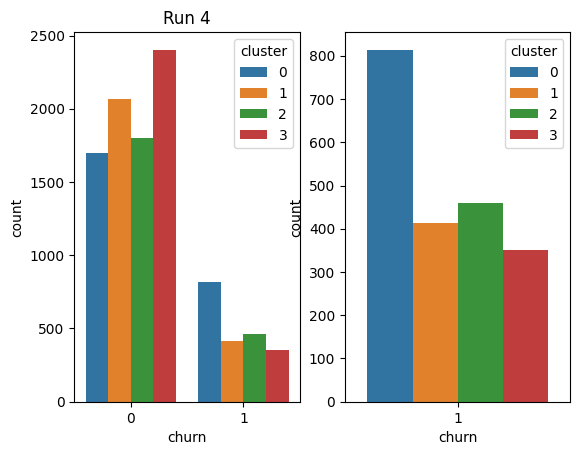

In [23]:

model = KMeans(init='k-means++', n_clusters=4, random_state=0,algorithm="elkan")
model.fit(df)

df['cluster'] = model.predict(df)
df['churn'] = churn_col

ply,ax=plt.subplots(1,2)
sns.countplot(x='churn', hue="cluster", data=df,ax=ax[0]).set(title='Run 4')


new_thing=[[i,j] for i,j in zip(df["churn"],df['cluster']) if i==1]
dfn = pd.DataFrame(list(new_thing),columns =['churn', 'cluster'])
sns.countplot(x='churn', hue="cluster", data=dfn,ax=ax[1])
ply.show()



In [24]:
new_thing_A=new_thing

for i in new_thing:
    del i[0]

new_thing=[int(i[0])for i in new_thing]
new_thing_A=[j for i,j in zip(df["churn"],df['cluster'])]

for i in range(4):
    print("Cluster "+str(i)+" Churn %=>",end="")
    print(round(float(op.countOf(new_thing,i)/op.countOf(new_thing_A,i)*100),3),end="%\n")


Cluster 0 Churn %=>32.443%
Cluster 1 Churn %=>16.673%
Cluster 2 Churn %=>20.345%
Cluster 3 Churn %=>12.713%


### We can see that it is usually the same cluster always has the most churn. <br> Now we will use the results from the analysis to improve our model.

### Explorator data analysis revealed to us that credit card , credit score, tenure, product number and estimated salary have a low correlation to churn.<br>
So now we will drop these columns. This will help kmeans double fold both by reducing dimentions and removing uncorrelated data.<br> However since these models have been around for a long time they have been fine tuned to such a degree that this will have a small but significant amount.

Cluster 0 Churn %=>46.057%
Cluster 1 Churn %=>20.416%
Cluster 2 Churn %=>23.649%
Cluster 3 Churn %=>11.011%


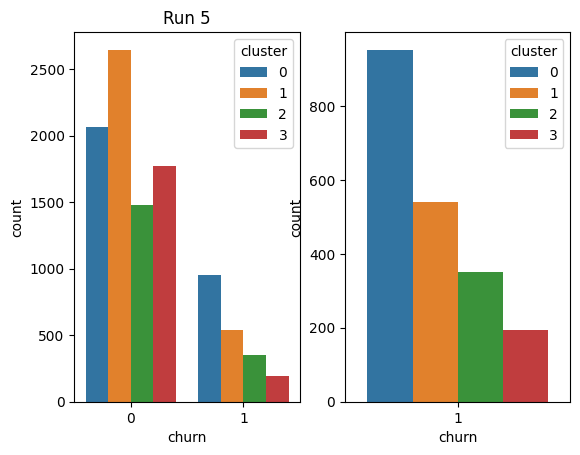

In [25]:
df1=df.drop(['credit_card','estimated_salary','credit_score','tenure','products_number','country','gender','cluster','churn'],axis=1).copy()
#Creating and fitting the model
model = KMeans(init='k-means++',n_clusters=4, random_state=0,algorithm="elkan")
model.fit(df1)
df1['cluster'] = model.predict(df1)
df1['churn'] = churn_col

ply,ax=plt.subplots(1,2)
sns.countplot(x='churn', hue="cluster", data=df1,ax=ax[0]).set(title='Run 5')

new_thing=[[i,j] for i,j in zip(df["churn"],df1['cluster']) if i==1]
new_thing2=[[i,j] for i,j in zip(df["churn"],df1['cluster']) if i==0]

dfn = pd.DataFrame(list(new_thing),columns =['churn', 'cluster'])
sns.countplot(x='churn', hue="cluster", data=dfn,ax=ax[1])
ply.show()



df_sad=pd.DataFrame(new_thing, columns =['Ar', 'ch'])
df_sad2=df_sad.groupby('ch').count()
df_sad1=pd.DataFrame(new_thing2, columns =['Ar', 'ch'])
df_sad3=df_sad1.groupby('ch').count()


for i in range(4):
    print("Cluster "+str(i)+" Churn %=>",end="")
    print(round(float((df_sad2['Ar'][i]/df_sad3['Ar'][i])*100),3),end="%\n")

### We can see a considerable improvent! While this is still not up to our standards it is still good!

## Now for the best model!

### From the same analysis we could see that age and balance had positive corrilation to the churn but active member has a negitive one. Now we will drop that one as well. 

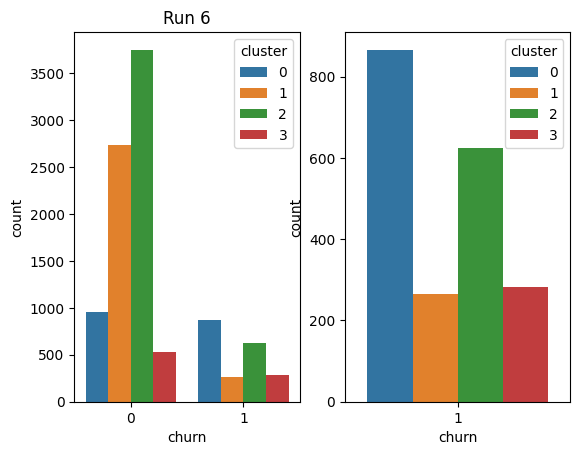

In [26]:
df1=df.drop(['credit_card','estimated_salary','credit_score','tenure','products_number','country','gender','cluster','churn','active_member'],axis=1).copy()
#Creating and fitting the model
model = KMeans(init='k-means++',n_clusters=4, random_state=0,algorithm="elkan")
model.fit(df1)
df1['cluster'] = model.predict(df1)
df1['churn'] = churn_col

df_saved=df1

ply,ax=plt.subplots(1,2)
sns.countplot(x='churn', hue="cluster", data=df1,ax=ax[0]).set(title='Run 6')

new_thing=[[i,j] for i,j in zip(df["churn"],df1['cluster']) if i==1]
new_thing2=[[i,j] for i,j in zip(df["churn"],df1['cluster']) if i==0]

dfn = pd.DataFrame(list(new_thing),columns =['churn', 'cluster'])
sns.countplot(x='churn', hue="cluster", data=dfn,ax=ax[1])
ply.show()



df_sad=pd.DataFrame(new_thing, columns =['Ar', 'ch'])
df_sad2=df_sad.groupby('ch').count()
df_sad1=pd.DataFrame(new_thing2, columns =['Ar', 'ch'])
df_sad3=df_sad1.groupby('ch').count()


In [27]:

for i in range(4):
    print("Cluster "+str(i)+" Churn %=>",end="")
    print(round(float((df_sad2['Ar'][i]/df_sad3['Ar'][i])*100),3),end="%\n")


Cluster 0 Churn %=>90.302%
Cluster 1 Churn %=>9.674%
Cluster 2 Churn %=>16.649%
Cluster 3 Churn %=>53.7%


## Look at that!! One cluster now has 90% churn and another with 53%! Not only this but the other clusters despite being significantly larger have extremly low churn!

### Now we have clusters that we can use! Any organisation using this model can now determine what is different about these 2 clusters.

Now lets us see a small visualization of these clusters.

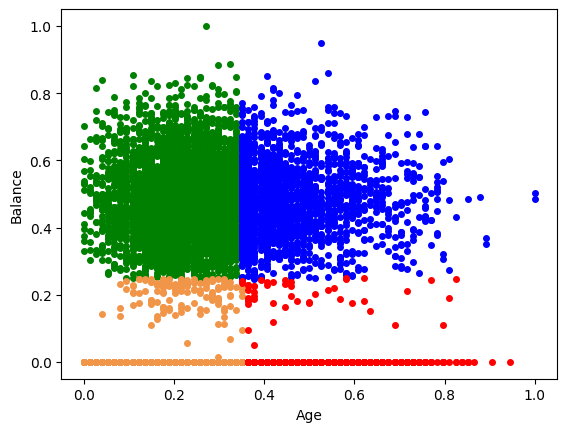

In [28]:

df1=df.drop(['credit_card','estimated_salary','credit_score','tenure','products_number','country','gender','cluster','churn','active_member'],axis=1).copy()
mo=KMeans(init='k-means++',n_clusters=4, random_state=4)
label=mo.fit_predict(df1)
#plotting the results:

cluster0 = df1[label == 0]
cluster1 = df1[label == 1]
cluster2 = df1[label == 2]
cluster3 = df1[label == 3]



#Plotting the results
plt.xlabel("Age")
plt.ylabel("Balance")
plt.scatter(cluster0.age , cluster0.balance , color = 'green' , s=16)
plt.scatter(cluster1.age , cluster1.balance , color = '#F19649' , s=16)
plt.scatter(cluster2.age , cluster2.balance , color = 'blue' , s=16)
plt.scatter(cluster3.age , cluster3.balance , color = 'red' , s=16)
plt.show()


# The above is a visual representation of the clusters formed. 

### We can see the blue and green are then ones with the high churn.

##### Now lets scale the data back up and see if we can spot any unique traits!

In [29]:
print(df_saved[["age","balance"]])

df_saved['age']=df_saved['age']/age_factor
df_saved['balance']=df_saved['balance']/balance_factor

print(df_saved)
df = df_saved.groupby(['cluster']).mean()
df[['age','balance']]

           age   balance
0     0.324324  0.000000
1     0.310811  0.334031
2     0.324324  0.636357
3     0.283784  0.000000
4     0.337838  0.500246
...        ...       ...
9995  0.283784  0.000000
9996  0.229730  0.228657
9997  0.243243  0.000000
9998  0.324324  0.299226
9999  0.135135  0.518708

[10000 rows x 2 columns]
            age        balance  cluster  churn
0     42.000042       0.000000        1      1
1     40.250040   83807.980099        2      0
2     42.000042  159661.028799        2      1
3     36.750037       0.000000        1      0
4     43.750044  125510.999861        0      0
...         ...            ...      ...    ...
9995  36.750037       0.000000        1      0
9996  29.750030   57369.692213        1      0
9997  31.500032       0.000000        1      1
9998  42.000042   75075.417585        2      1
9999  17.500018  130142.976499        2      0

[10000 rows x 4 columns]


,age,balance
cluster,,
0,59.494306,120304.653019
1,28.356694,2420.006144
2,27.732244,122589.483929
3,63.503459,2592.216122


### Now look at that! We can see in cluster 0 the age is high and high balance and for cluster 3 age is high with low balance! 
#### From this we can realise that older people have a much higher chance of churn! Whats more is that older people with lot of money are moving away.<br> This is a true nightmare for any bank. Older people with money are the best money makers for banks. At least in terms of ethical money making.